 -----------------------------------------------------------------------------------------------------------------------

GRUPO: G_4_6

Magda Costa - up202207036

Rafael Pacheco - up202206258

Sofia Machado - up202207203

 -----------------------------------------------------------------------------------------------------------------------

# Machine Learning I (CC2008) - Practical Assignment


## Índice  <a name = "indice"></a>
1. [Introdução](#introdução)
2. [Algoritmo Escolhido](#algoritmo)
    - [Explicação KNN](#exp_knn)
    - [Código KNN](#codigo_knn)
    - [Complicações do KNN](#comp_knn)
3. [Problema Escolhido - Classes Desbalanceadas](#problema)
    - [Como Resolver?](#resolver)
4. [Testar o Algoritmo nos Datasets](#teste_algoritmo)
5. [Como Melhorar?](#como_melhorar)
6. [Melhoria do Algoritmo](#melhorar)
    - [Pesos](#pesos)
    - [Distâncias Ponderadas](#dp)
7. [Avaliação dos Algoritmos](#avaliação)
    - [Código dos Testes](#ct)
    - [Testes](#testes)
    - [Análise dos Resultados](#analise_resultados)
    
8. [Conclusão](#conclusão)

 -----------------------------------------------------------------------------------------------------------------------

## Introdução <a name = "introdução"></a>
[[voltar ao índice]](#indice)

Este trabalho tem como objetivo desenvolver e avaliar uma adaptação de um algoritmo de classificação. A análise será realizada com datasets disponíveis no OpenML, conforme sugerido. 

Como sabemos, o desempenho dos algoritmos de Machine Learning (ML) pode ser significativamente comprometido por desafios inerentes aos dados do mundo real, como atributos qualitativos com muitos valores possíveis, ruído, outliers, desbalanceamento de classes, multiclasses e sobreposição de classes.

Através da seleção de um algoritmo de classificação, vamos analisar o funcionamento teórico e prático, ao identificar uma característica dos dados que o afeta. Após esta análise, implementaremos uma alteração no algoritmo para melhorar a sua performance. Finalmente, vamos reavaliar o algoritmo modificado e comparar os resultados com a versão original.

Este estudo visa compreender melhor os desafios que os dados reais apresentam aos algoritmos de ML e como adaptar estes algoritmos para obter modelos mais precisos e eficazes.

Para realizar este trabalho foram utilizadas as seguintes bibliotecas:

In [1]:
# Imports necessários
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import random
from math import log2
from collections import Counter
from scipy import stats
from sklearn.metrics import confusion_matrix as cm, accuracy_score as ac, precision_score as pr, balanced_accuracy_score as bac, f1_score as f1
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean

## Algoritmo Escolhido <a name = "algoritmo"></a>
[[voltar ao índice]](#indice)

### Explicação KNN <a name = "exp_knn"></a>
[[voltar ao índice]](#indice)

**K-Nearest Neighbors**, ou simplesmente **K-nn**, é um dos algoritmos de classificação mais simples e utiliza distâncias para avaliar o grau de semelhança entre instâncias e, consequentemente, classificá-las. Para isso, serve-se dos **k objetos** mais próximos (ou seja, mais semelhantes) ao novo exemplo.


#### Fase de treino 

Numa fase de treino, o algoritmo guarda os objetos de treino em memória. Isto significa que todos os atributos de uma instância passada ao algoritmo serão memorizados para comparação futura, ou seja, não existe propriamente uma **fase de aprendizagem**.


#### Fase de previsão

Quando pretendemos classificar um novo exemplo, o algoritmo **calcula as distâncias** possíveis entre a nova instância e todos os objetos de treino.

Após processar todos esses cálculos, as **distâncias são associadas aos objetos** de treino e sucessivamente **ordenadas por ordem crescente** num processo de **ranking**: a distância mais baixa tem rank 1, a segunda mais baixa tem rank 2, e assim sucessivamente.

De seguida, de acordo com o valor de k previamente estabelecido, escolherá os **k objetos com melhor ranking**. 
Este processo garante que os exemplos com valores de atributos **mais próximos** sejam os considerados, já que quanto **mais semelhantes** em relação à nova instância, menor será a distância entre eles, pelo que o seu ranking será mais alto.

Concluída a seleção dos k melhores objetos, segue-se a **análise da classe** a que os mesmos pertencem, pelo que a classificação da nova instância será feita com base na **classe maioritária dos k elementos escolhidos**.

### Código KNN <a name = "codigo_knn"></a>
[[voltar ao índice]](#indice)

Para o desenvolvimento de métodos de resolução de classes desbalanceadas, decidimos utilizar a implementação de K-Nn fornecida no guião:

 - https://github.com/rushter/MLAlgorithms

In [2]:
class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if X.size == 0:
            raise ValueError("Got an empty matrix.")
        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])
        
        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")
            if not isinstance(y, np.ndarray):
                y = np.array(y)
            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")
        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()



# K-nn
class KNNBase(BaseEstimator):
    def __init__(self, k=5, distance_func=euclidean):
        self.k = None if k == 0 else k  # l[:None] returns the whole list
        self.distance_func = distance_func

    def aggregate(self, neighbors_targets):
        raise NotImplementedError()

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]
        return np.array(predictions)

    def _predict_x(self, x):
        """Predict the label of a single instance x."""

        # compute distances between x and all examples in the training set.
        distances = (self.distance_func(x, example) for example in self.X)

        # Sort all examples by their distance to x and keep their target value.
        neighbors = sorted(((dist, target) for (dist, target) in zip(distances, self.y)), key=lambda x: x[0])

        # Get targets of the k-nn and aggregate them (most common one or average).
        neighbors_targets = [target for (_, target) in neighbors[: self.k]]

        return self.aggregate(neighbors_targets)


class KNNClassifier(KNNBase):
    """Nearest neighbors classifier."""

    def aggregate(self, neighbors_targets):
        """Return the most common target label."""

        most_common_label = Counter(neighbors_targets).most_common(1)[0][0]
        return most_common_label


class KNNRegressor(KNNBase):
    """Nearest neighbors regressor."""

    def aggregate(self, neighbors_targets):
        """Return the mean of all targets."""


        return np.mean(neighbors_targets)

No entanto após analisar o código percebemos que alguns funções não são necessárias para o seu funcionamento, uma vez que não estão implementadas. Segue em baixo o código com apenas as funções necessárias para o seu funcionamento e a respetiva explicação. De notar que foi alterado o código de modo a que seja possivel determinar qual o número de vizinhos a analizar quando se cria KNNClassifier(), mantemos, no entanto, a métrica de distância como euclidiana, não sendo possivel alterá-la.

#### 1. Base Estimator

A classe ```BaseEstimator``` verifica se os dados fornecidos estão guardados no formato pretendido. Caso isso não aconteça, os dados são convertidos para **arrays de numpy**:

In [3]:
class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if X.size == 0:
            raise ValueError("Got an empty matrix.")
        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])
        
        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")
            if not isinstance(y, np.ndarray):
                y = np.array(y)
            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")
        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

#### 2. Implementação de K-nearest Neighbors

Estas classes servem de base para classificar ou usar regressão nos dados usando o modelo ``` K-nearest Neighbors```. 

`KNNBase` possui valores implícitos, caso estes não sejam passados à função:

 - Número de vizinhos, **k**: 5

 - Métrica de distância usada pelo algoritmo automaticamente, **distance_func**: euclideana


Segue abaixo uma breve explicação das classes e das respetivas funções principais:

 1.  `KNNBase` -> **\_predict\_** :

      - Calcula **distâncias** entre o novo valor de target e os valores existentes e guarda em pares de (distância, classe)
    
      - Ordena pares por **'ranks'**

      - Classe final é determinada através da classe mais comum entre vizinhos (**mode**) ou a média (**average**)

 
 2. `KNNClassifier` -> **aggregate** :

      - `Nota`: se houver empate entre a escolha de classes, a decisão é arbitrária

      - Usa 'Counter' para contar as ocorrências de cada classe

 3. `KNNRegressor` -> **aggregate** :
     
      - Devolve a média de todos os valores da classe target 


In [4]:
# K-nn
class KNNBase(BaseEstimator):
    def __init__(self, k = 5, distance_func = euclidean):
        self.k = None if k == 0 else k  # l[:None] returns the whole list
        self.distance_func = distance_func

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]
        return np.array(predictions)

    def _predict_x(self, x):
        """Predict the label of a single instance x."""

        # compute distances between x and all examples in the training set.
        distances = (self.distance_func(x, example) for example in self.X)

        # Sort all examples by their distance to x and keep their target value.
        neighbors = sorted(((dist, target) for (dist, target) in zip(distances, self.y)), key=lambda x: x[0])

        # Get targets of the k-nn and aggregate them (most common one or average).
        neighbors_targets = [target for (_, target) in neighbors[: self.k]]

        return self.aggregate(neighbors_targets)

    
"""Nearest neighbors classifier."""
class KNNClassifier(KNNBase):
    def __init__(self, n_neighbors = 5):
        super().__init__(k = n_neighbors)

    def aggregate(self, neighbors_targets):
        """Return the most common target label."""
        most_common_label = Counter(neighbors_targets).most_common(1)[0][0]
        return most_common_label

    
"""Nearest neighbors regressor."""
class KNNRegressor(KNNBase):

    def aggregate(self, neighbors_targets):
        """Return the mean of all targets."""
        return np.mean(neighbors_targets)

### Complicações do KNN <a name = "comp_knn"></a>
[[voltar ao índice]](#indice)

De modo a que futuramente possamos escolher qual a complicação do KNN que queremos resolver, iremos numa fase inicial analisar os diferentes problemas que podemos encontrar:

#### - Valor de k

Embora não seja dependente da existência das complicações abaixo elaboradas (é apenas um parâmetro), o primeiro problema que encontramos quando usamos este algoritmo é a definição de um **valor ideal para k**. 

Se o valor for **muito baixo**, o classificador torna-se muito sensível a exemplos muito semelhantes à nova instância, podendo fazer **overfitting**, focando-se em valores específicos que são nocivos para uma classificação mais abrangente. Para além disso, é muito mais suscetível à consideração de **outliers** no dataset, podendo tomar decisões totalmente inconsistentes com a realiade, baseadas em **valores excepcionais** que são **significativamente diferentes** da generalidade das instâncias de treino.

No entanto, se k apresentar um valor **muito elevado**, o algoritmo não só tem **tendência para escolher** a **classe maioritária** mas também focar-se em **instâncias pouco semelhantes** ao novo objeto (**generalização excessiva**), conduzindo a classificações incorretas. É fácil de perceber que uma consideração mais ampla de exemplos aumenta também a probabilidade de escolher **ruído do dataset** como opção de classificação do novo exemplo.

Posto isto, percebemos que é fundamental escolher um valor de k que apresente um bom **tradeoff** entre as complicações anteriormente referidas, com a finalidade de refinar a capacidade de classificação do algoritmo.

Apesar disto, como o foco deste projeto não é otimização de parâmetros, **decidimos não investigar** em profundidade um valor de k ótimo para os dataset em questão.

#### - Atributos qualitativos com muitos valores 

Para além de ser necessário aplicar algum tipo de **encoding** aos valores qualitativos para fornecer ao algoritmo algum tipo de métrica de **comparação entre instâncias**, uma quantidade elevada de valores aumenta consideravelmente a exigência computacional do algoritmo aquando do cálculo de várias distâncias. 

Uma das resoluções possíveis para este problema seria **redução de dimensionalidade**, o que implica, na maioria dos casos, a perda de dados ou características dos mesmos.

#### - Ruído e outliers

A presença de valores irrelevantes ou de outliers pode causar classificações indevidas, especialmente para um algoritmo como o K-nn, já que se **baseia apenas em semelhanças** entre instâncias e **não possui** uma fase de aprendizagem capaz de **distinguir padrões pertinentes de aleatórios** como, por exemplo, as **Support Vector Machines** (SVMs), que utilizam conceitos como hiperplanos e kernels capazes de mapear os dados para espaços de diferentes dimensões para detetar até padrões significativamente complexos, sendo por isso mais robustos a este tipo de problemas.

Para mitigar esta complicação, podemos aplicar uma análise dos valores do dataset e **remover outliers** e valores que determinamos ser **correlacionados de forma excessivamente alta ou baixa**.

#### - Multiclasses

Em datasets multiclasse, é realmente **desafiante encontrar termos comparativos** devido à possibilidade do **aumento da dimensionalidade** e de **dispersão de objetos** pelo espaço, bem como o aumento da complexidade de padrões que o K-nn pode não ser capaz de detetar.

Neste caso, as melhores opções de resolução ao problema seriam reduzir a dimensionalidade ou **utilizar outro algoritmo** de classificação alternativo, mais robusto a este problema, como por exemplo as SVM anteriormente mencionadas.

#### - Classes sobrepostas

O algoritmo K-nn será **gravemente afetado** pela presença de classes sobrepostas nos seus dados de treinamento. Este problema complica de forma significativa a **capacidade de distinção de classe** de um novo exemplo devido à **alta semelhança** entre instâncias **de classes distintas**, criando regiões onde a decisão do algoritmo pode ser verdadeiramente **ambígua e incorreta** com uma probabilidade relativamente elevada, o que **reduz consideravelmente a precisão** do algoritmo.

Se um bom **pré-processamento** dos dados onde se aplica **remoção de outliers e normalização** de valores não for capaz de reduzir este problema de forma a que o algoritmo não seja tão afetado pelo mesmo, **sugere-se** o uso de um **algoritmo de classificação alternativo** (mais uma vez, SVMs são relativamente robustas à existência de classes sobrespostas devido à sua capacidade de usar **"kernel tricks"**).

#### - Classes desbalanceadas

A existência de classes fortemente desbalanceadas num dataset é **extremamente nociva** para o algoritmo em questão, por fundamentar a sua classificação na classe maioritária dos k elementos com maior semelhança de atributos comparativamente com o novo objeto. Um erro muito comum em classificações de datasets com este problema é a rejeição da classe correta devido à porporção da classe maioritária, **M**, relativamente à classe minoritária, **m**. É possível que, mesmo com um valor de k ideal e otimizado, ao ter uma **classe minoritária com uma boa semelhança** ao novo exemplo e uma **classe maioritária completamente distinta** do mesmo, os k vizinhos mais próximos sejam algo do tipo:

 - m m M M M M 

Onde a classe minoritária, m, **seria descartada** simplesmente por ser inferior em número, **apesar de ser a classificação correta.**

## Problema Escolhido - Classes Desbalanceadas <a name = "problema"></a>
[[voltar ao índice]](#indice)

Para este trabalho decidimos escolher 'Classes Desbalanceadas' como o problema a ser resolvido, uma vez que percebemos que é algo que pode causar diversos problemas ao algoritmo como foi mencionado previamente. Para além disso quando fizemos uma pesquisa mais aprofundada entre os diversos problemas, este foi aquele que mais nos apelou.

### Como Resolver?<a name = "resolver"></a>
[[voltar ao índice]](#indice)

#### Ajuste de Pesos
Uma maneira de resolver este gravíssimo problema é **associar pesos a instâncias das classes**, de forma a atribuir mais importância a classes minoritárias, como tentativa de equilibrar o facto de se encontrarem em **desvantagem numérica**. 

Ao ajustar os pesos das instâncias, garantimos que as amostras de classes minoritárias tenham uma **maior contribuição** na decisão final do algoritmo. Isto significa que, mesmo que as instâncias de uma classe minoritária sejam numericamente menores, elas podem exercer uma **influência proporcionalmente maior** na classificação, evitando que a classe correta seja descartada injustamente.

Por exemplo, se os k vizinhos mais próximos consistem em três instâncias da classe maioritária e três da classe minoritária, o ajuste de pesos pode garantir que as instâncias minoritárias, ao receberem pesos maiores, tenham um **impacto maior** na determinação da classe final do novo exemplo.

#### Distâncias Ponderadas

Decidimos também implementar o conceito de **distâncias ponderadas**, onde cada vizinho contribui para a decisão da classe com um peso proporcional à inversa da sua distância ao novo exemplo. Desta forma, **os vizinhos mais próximos** têm um impacto maior na classificação do que os vizinhos mais afastados. Este ajuste na ponderação das distâncias permite que o algoritmo leve em consideração não apenas a proximidade absoluta, mas também a **relevância relativa** de cada vizinho.

Assim, por exemplo, se os vizinhos mais próximos consistirem em três instâncias da classe maioritária e três instâncias da classe minoritária, as instâncias da classe minoritária contribuirão mais para a decisão de classificação, mesmo que sejam menos numerosas. Isto ajuda a evitar que a classe correta seja descartada simplesmente por ser minoritária.

Em resumo, ao implementar distâncias ponderadas no algoritmo k-NN, podemos **mitigar os efeitos prejudiciais** das classes desbalanceadas, garantindo que a classificação leve em consideração tanto a proximidade dos vizinhos quanto a distribuição das classes no conjunto de dados. O que leva a um modelo mais justo e preciso, capaz de lidar, de maneira eficaz, com conjuntos de dados desbalanceados.

Ao utilizarmos o ajuste de pesos e as distâncias ponderadas, podemos ajustar a **sensibilidade do algoritmo** ao desequilíbrio entre as classes, permitindo um melhor **equilíbrio entre a precisão** na classificação das classes minoritárias e a capacidade de **generalização** para todas as classes.

### Testar o Algoritmo nos Datasets<a name = "teste_algoritmo"></a>
[[voltar ao índice]](#indice)

#### 1. Leitura e Análise dos Datasets

Para avaliar a eficiência das funções acrescentadas, é necessário ter um ponto de partida relativamente ao desempenho do algoritmo em questão, sem métodos de resolução dos problemas.

Primeiro, passar dados csv para um dataframe:

In [5]:
df_bt = pd.read_csv('clean_ds/blood_transfusion.csv')
df_breast = pd.read_csv('clean_ds/breast_w.csv')
df_diabetes = pd.read_csv('clean_ds/diabetes.csv')
df_fertility = pd.read_csv('clean_ds/fertility.csv')
df_haberman = pd.read_csv('clean_ds/haberman.csv')
df_liver = pd.read_csv('clean_ds/liver_disorders.csv')
df_lupus = pd.read_csv('clean_ds/lupus.csv')
df_sa = pd.read_csv('clean_ds/sa_heart.csv')
df_weather = pd.read_csv('clean_ds/weather.csv')

Vamos confirmar que os datasets foram importados corretamente, para isso iremos fazer dataset.head().

[[dar skip à visualização dos dados]](#skip)

In [6]:
df_bt.head()

,V1,V2,V3,V4,CLASS
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [7]:
df_breast.head()

,CLUMP,SIZE,SHAPE,ADHESION,EPI_SIZE,NUCLEI,CHROMATIN,NUCLEOLI,MITOSES,CLASS
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


In [8]:
df_diabetes.head()

,PREG,PLAS,PRES,SKIN,INSU,MASS,PEDI,AGE,CLASS
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
df_fertility.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,CLASS
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,0
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,1
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,0
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,0
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,1


In [10]:
df_haberman.head()

,AGE,YEAR,NODES,CLASS
0,30,64,1,0
1,30,62,3,0
2,30,65,0,0
3,31,59,2,0
4,31,65,4,0


In [11]:
df_liver.head()

,DRINKS,MCV,ALKPHOS,SGPT,SGOT,GAMMAGT,CLASS
0,85,92,45,27,31,0.0,0
1,85,64,59,32,23,0.0,1
2,86,54,33,16,54,0.0,1
3,91,78,34,24,36,0.0,1
4,87,70,12,28,10,0.0,1


In [12]:
df_lupus.head()

,TIME,CLASS,DURATION,LOG
0,157,1,1.0,0.69
1,268,1,10.0,2.40
2,209,0,2.0,1.10
3,134,1,0.1,0.10
4,21,0,0.1,0.10


In [13]:
df_sa.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,CLASS
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,2,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [14]:
df_weather.head()

,ID,Weather,Temp,Humidity,Windy,CLASS
0,1,0,85,85,0,0
1,2,0,80,90,1,0
2,3,1,83,86,0,1
3,4,2,70,96,0,1
4,5,2,68,80,0,1


**Fim de skip**<a name = "skip"></a>

Os datasets foram importados com sucesso.

#### 2. Divisão entre Attributes e Target

De seguida, precisamos de preparar um split para os dados e inicializar, treinar e testar o classificador **K-nn** para cada um dos datasets representados:

In [15]:
# blood_transfusion.csv
X_bt = df_bt[['V1','V2','V3','V4']]
y_bt = df_bt['CLASS']

In [16]:
# breast_w.csv
X_breast = df_breast[['CLUMP','SIZE','SHAPE','ADHESION','EPI_SIZE','NUCLEI','CHROMATIN','NUCLEOLI','MITOSES']]
y_breast = df_breast['CLASS']

In [17]:
# diabetes.csv
X_diabetes = df_diabetes[['PREG','PLAS','PRES','SKIN','INSU','MASS','PEDI','AGE']]
y_diabetes = df_diabetes['CLASS']

In [18]:
# fertility.csv
X_fertility = df_fertility[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']]
y_fertility = df_fertility['CLASS']

In [19]:
# haberman.csv
X_haberman = df_haberman[['AGE','YEAR','NODES']]
y_haberman = df_haberman['CLASS']

In [20]:
# liver_disorders.csv
X_liver = df_liver[['DRINKS','MCV','ALKPHOS','SGPT','SGOT','GAMMAGT']]
y_liver = df_liver['CLASS']

In [21]:
# lupus.csv
X_lupus = df_lupus[['TIME', 'DURATION', 'LOG']]
y_lupus = df_lupus['CLASS']

In [22]:
# sa_heart.csv
X_sa = df_sa[['V1','V2','V3','V4','V5','V6','V7','V8','V9']]
y_sa = df_sa['CLASS']

In [23]:
# transplant.csv
X_weather = df_weather[['Weather', 'Temp', 'Humidity', 'Windy']]
y_weather = df_weather['CLASS']

Nesta lista juntamos todos os dados divididos em tuplos

In [24]:
split_data = [(X_bt,y_bt), (X_breast,y_breast), (X_diabetes,y_diabetes), (X_fertility,y_fertility), 
              (X_haberman,y_haberman), (X_liver,y_liver),(X_lupus,y_lupus), (X_sa,y_sa), (X_weather,y_weather)]

#### 3. Teste do código nos datasets

Uma vez lidos e divididos em features e target iremos usar as seguintes funções que nos permitem automatizar o processo de classificação e visualização da accuracy.

In [25]:
# função responsável por fazer split de dados, treinar classificador
# e obter arrays com os dados para as métricas 

def all_test(split_data):
    
    # inicializar listas
    pred_list = []
    ytest = []


    # iterar sobre datasets
    for i in range(len(split_data)):
        # inicializar classificador
        knn_classifier = KNNClassifier()

        # fazer o split dos dados
        X = split_data[i][0]
        y = split_data[i][1]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

        # treinar classificador
        knn_classifier.fit(X_train,y_train)

        # fazer previsão e guardar valores previstos e de teste
        y_pred = knn_classifier.predict(X_test)
        pred_list.append(y_pred)
        ytest.append(y_test)

    # devolver resultados
    return pred_list, ytest


# função responsável por imprimir resultados

def all_eval(predictions_list,ytest_list):
    names = {1:'blood_transfusion performance:\n', 
       2:'breast_w  performance:\n', 
       3:'diabetes performance:\n', 
       4: 'fertility performance:\n',
       5:'haberman performance:\n',
       6:'liver_disorders performance:\n',
       7:'lupus performance:\n',
       8:'sa_heart performance:\n', 
       9:'weather performance:\n'}

    # Imprimir performance para cada dataset 
    for i in range(9):
        print(f"{i+1}. {names[i+1]}")
        print(f"Accuracy: {ac(predictions_list[i],ytest_list[i])}")
        print()
        print('---------------------------\n')


def full_metrics(split_data):
    # obter listas com previsões e valores de teste
    pred_list, ytest = all_test(split_data)
    
    print()
    # obter resultados das métricas de avalição
    all_eval(pred_list,ytest)

Usando as funções previamente definidas:

In [26]:
full_metrics(split_data)


1. blood_transfusion performance:

Accuracy: 0.7777777777777778

---------------------------

2. breast_w  performance:

Accuracy: 0.9658536585365853

---------------------------

3. diabetes performance:

Accuracy: 0.7532467532467533

---------------------------

4. fertility performance:

Accuracy: 0.8666666666666667

---------------------------

5. haberman performance:

Accuracy: 0.7282608695652174

---------------------------

6. liver_disorders performance:

Accuracy: 0.6153846153846154

---------------------------

7. lupus performance:

Accuracy: 0.7777777777777778

---------------------------

8. sa_heart performance:

Accuracy: 0.6115107913669064

---------------------------

9. weather performance:

Accuracy: 0.6

---------------------------



Para que se possam compreender melhor os resultados devemos saber as seguintes noções:

**Accuracy**

Alta: Indica que uma grande proporção das previsões do modelo está correta. O modelo é geralmente eficaz em distinguir entre as classes.

Baixa: Sugere que o modelo comete muitos erros ao fazer previsões. Pode indicar que o modelo não é adequado para os dados ou está mal configurado.

**Conclusão**

A análise dos datasets foi realizada várias vezes durante testes por nós executados, no entanto de modo a manter o Notebook fácil de compreender apenas deixamos uma dessas execuções. Contudo, devemos ter em conta que para alguns splits que não se encontram aqui representados os valores da accuracy variaram bastante, dependendo estes da divisão dos dados. 

Para além do valor anormal do dataset 'breast_w', excecionalmente alto, os resultados obtidos pelo KNN parecem estar de acordo com os datasets que apresentam classes desbalanceadas. Devemos também mencionar que nos diversos testes realizados a accuracy de 'Weather' apresentou valores muito distintos, provavelmente devido à escassez de exemplos em certos splits. Pensamos também que a anormalidade de 'breast_w' se deve ao facto das classes estarem bem divididas, como foi possivel observar no Jupyter Notebook do Tratamento de Dados.

### Como Melhorar <a name = "como_melhorar"></a>
[[voltar ao índice]](#indice)

Para este projeto, foram escolhidos 2 modos de lidar com o problema de **classes desbalanceadas** que identificámos em todos os datasets em questão, provenientes de OpenML:
   - **Ajuste de peso das classes**
   - **Ajuste da distância**

Deste modo, vamos implementar estas medidas e analisar a sua eficiência.

`Notas Importantes:` 
 - É possível que os datasets recolhidos **apresentem outros tipos de complicações**, tais como classes sobrepostas ou atributos irrelevantes. **Segundo as instruções do guião e após confirmação com docente**, vamos apenas  explicar que apesar de as nossas funções estarem corretamente implementadas, os resultados podem não ser ideais, devido às complicações mencionadas anteriormente.

#### 4.1. Ajuste de Peso

De forma a equilibrar o impacto das instâncias de ambas as classes, é calculado,`durante o processo de treino do modelo`, que peso dar a cada classe, sendo que é dado um **peso maior** às instâncias da classe **minoritária**, de modo a que esta passe a ter uma maior relevância e influência. Após serem escolhidos os k vizinhos mais próximos usamos os pesos para nos ajudar a decidir qual a classificação correta.

#### 4.2. Ajuste da distância

Neste método utilizamos a mesma técnica de cálculo de pesos utilizada no 'Ajuste de peso das classes', mas em vez de estes serem atribuidos após a escolha dos k vizinhos mais próximos, os pesos são multiplicados pelas distâncias a que os dados se encontram uns dos outros, de modo a influenciar a relevância de todos os dados, sendo assim os k vizinhos escolhidos tendo em conta o peso e a distância.

### Melhoria do Algoritmo <a name = "melhorar"></a>
[[voltar ao índice]](#indice)

Nesta parte do projeto o objetivo é melhorar o código do KNN que se encontra a cima para o problema das classes desbalanceadas.

#### 1. Melhoria K-nearest Neighbors - Pesos <a name = "pesos"></a>
[[voltar a Melhoria do Algoritmo]](#melhorar)

Relativamente a BaseEstimator **não serão realizadas quaisquer alterações** uma vez que esta classe tem como único propósito ver se os dados estão no formato correto para serem utilizados e caso não estejam corvertê-los para tal. De qualquer das formas, decidimos incluí-lo de novo para que seja mais fácil entender o código do classificador melhorado como um todo:

In [27]:
class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if X.size == 0:
            raise ValueError("Got an empty matrix.")
        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])
        
        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")
            if not isinstance(y, np.ndarray):
                y = np.array(y)
            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")
        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

Para que posteriormente possam ser realizados testes com o KNN sem melhoria e após realizar alterações, serão mudados os nomes das classes, para que não haja dúvidas de quais estão a ser chamadas. Reforçamos que BaseEstimator não sofreu alterações, logo será utilizado tanto para o KNN melhorado como para o antigo, não havendo, portanto, a necessidade de alterar o seu nome.

Mudança dos nomes:

                              Antigo                    Novo
                       -----------------------------------------------
                           KNNBase         ->      KNNBase_P
                           KNNClassifier   ->      KNNClassifier_P
                           KNNRegressor    ->      KNNRegressor_P             

Com o objetivo de lidar com as classes desbalanceadas, vamos aplicar atribuições de pesos a classes, com inspiração no método da **Ponderação Equilibrada de Classes (BWC)**.

**-> Ponderação Equilibrada de Classes:** é uma técnica utilizada em problemas de classificação para lidar com conjuntos de dados desbalanceados. Ela é uma abordagem que visa **equilibrar o impacto das diferentes classes**, atribuindo **pesos apropriados durante o processo de classificação**, de modo que classes **menos frequentes tenham um peso maior** do que as classes mais frequentes. A seguinte fórmula proporciona uma boa métrica para avaliar qual o peso a ser atribuido às classes:
                
             Peso da classe = Número total de amostras / (Número de classes * Número de amostras daquela classe)

Decidimos utilizar o BWC para a atribuição de pesos uma vez que esta técnica os ajusta de forma proporcional e equilibrada, pois considera não só a frequência de cada classe como o número total de classes. Para além disso, a fórmula normaliza os pesos de modo a que seja possivel evitar pesos excessivamente grandes ou pequenos, mantendo a influência de cada classe numa escala mais uniforme, algo que não aconteceria se usassemos a Ponderação Inversa da Frequência de Classe (IFW).

Vamos então fazer alterações ao código incluindo a ponderação de pesos. De um modo geral o funcionamento será o seguinte:

    - Quando se usa 'fit' a função vai ser ativada em KNNClassifier_P, mas vai buscar na mesma o 'fit' no BaseEstimator, ou seja, até aqui não haveriam alterações. A única diferença é que no 'fit' do KNNClassifier_P vão ser também calculados os pesos que se devem dar a cada classe usando a função calculate_class_weights que funciona de acordo com o BWC.

    - Durante a classificação, ou seja, quando se ativa a função predict, o código irá funcionar normalmente, isto é, calcula quais os pontos mais próximos ao que estamos a avaliar. No entanto, quando passar para 'aggregate' do KNNClassifier_P, em vez de escolher o 'label' mais comum, irá funcionar do seguinte modo:
       
        1. Calcula o número de vezes que cada 'label' aparece
        2. Multiplica o peso de cada classe pelo número de vezes que esta apareceu
        3. Escolhe o label com maior pontuação.

Agora que explicamos aquilo que decidimos fazer, iremos passar às alterações realizadas:

In [28]:
# KNN com Pesos
class KNNBase_P(BaseEstimator):
    def __init__(self, k = 5, distance_func = euclidean):
        self.k = None if k == 0 else k  # l[:None] returns the whole list
        self.distance_func = distance_func

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]
        return np.array(predictions)

    def _predict_x(self, x):
        """Predict the label of a single instance x."""

        # compute distances between x and all examples in the training set.
        distances = (self.distance_func(x, example) for example in self.X)

        # Sort all examples by their distance to x and keep their target value.
        neighbors = sorted(((dist, target) for (dist, target) in zip(distances, self.y)), key=lambda x: x[0])

        # Get targets of the k-nn and aggregate them (most common one or average).
        neighbors_targets = [target for (_, target) in neighbors[: self.k]]

        return self.aggregate(neighbors_targets)

    
"""Nearest neighbors classifier."""
class KNNClassifier_P(KNNBase_P):
    def __init__(self, n_neighbors = 5, class_weights = None):
        super().__init__(k = n_neighbors)
        self.class_weights = class_weights  # Dicionário que guarda o nome da classificação e o respetivo peso: {nome: peso}

    # Esta função usa na mesma o fit do BaseEstimator, mas também calcula os pesos que se deve dar a cada classe
    def fit(self, X, y=None):
        super()._setup_input(X, y)
        if self.class_weights == None:
            self.class_weights = self.calculate_class_weights(y)

    # Função que usa o BWC para calcular o peso de cada classe
    def calculate_class_weights(self, y):
        class_counts = Counter(y)   # Devolve um dicionário com cada classificação e o número de vezes que apareceu   Ex: {1: 178, 0: 570}
        total_samples = len(y)  # número total de exemplos em y
        class_weights = {}
        for label, count in class_counts.items():
            class_weights[label] = total_samples / (len(class_counts) * count)
        
        return class_weights 

    
    def aggregate(self, neighbors_targets):
        class_counts = Counter(neighbors_targets)
        weighted_classes = {label: class_counts[label] * weight for label, weight in self.class_weights.items()}
        return max(weighted_classes, key = weighted_classes.get)
    
    
"""Nearest neighbors regressor."""
class KNNRegressor_P(KNNBase_P):

    def aggregate(self, neighbors_targets):
        """Return the mean of all targets."""
        return np.mean(neighbors_targets)

De modo a perceber se o algoritmo melhorou, vamos fazer um teste rápido com apenas uma iteração.

0.5961538461538461
0.625


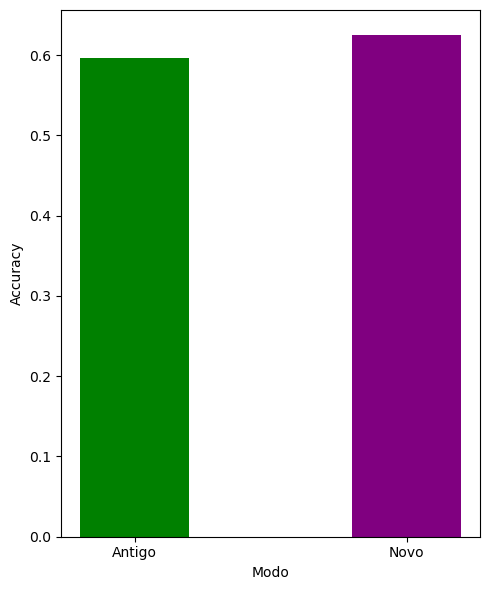

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_liver,y_liver,test_size=0.3,random_state=49)

# inicializar classificador
knn_classifier_antigo = KNNClassifier()
knn_classifier_novo = KNNClassifier_P()

# treinar classificador
knn_classifier_antigo.fit(X_train,y_train)
knn_classifier_novo.fit(X_train,y_train)

# fazer previsão e guardar valores previstos e de teste
pred_antigo = knn_classifier_antigo.predict(X_test)
pred_novo = knn_classifier_novo.predict(X_test)

# accuracy
ac_antigo = ac(pred_antigo,y_test)
print(ac_antigo)
ac_novo = ac(pred_novo,y_test)
print(ac_novo)

plt.figure(figsize=(5, 6))
plt.bar(['Antigo', 'Novo'], [ac_antigo, ac_novo], color=['green', 'purple'], width=0.4)
plt.xlabel('Modo')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

#### 2. Melhoria K-nearest Neighbors - Distâncias Ponderadas <a name = "dp"></a>
[[voltar a Melhoria do Algoritmo]](#melhorar)

Como percebemos pelos testes realizados anteriormente talvez os pesos não sejam a melhor opção. Iremos agora testar a técnica das **Distâncias Ponderadas**. O 'BaseEstimator' não irá sofrer nenhuma alteração, no entanto iremos mudar os nomes às restantes classes para que não haja dúvidas de quais estamos a utilizar.

Mudança dos nomes:

                              Antigo                    Novo
                       -----------------------------------------------
                           KNNBase         ->      KNNBase_D
                           KNNClassifier   ->      KNNClassifier_D
                           KNNRegressor    ->      KNNRegressor_D
                           

Como funciona:

    - Começamos por contar as ocorrências de cada classe no conjunto de dados. Isto geralmente é feito contando quantas vezes cada classe aparece nos rótulos de destino.

    - Em seguida, é calculado um peso para cada classe. Utilizamos também o BWC.
            
    - Durante a classificação, as distâncias entre o ponto a ser classificado e os pontos de treinamento são calculadas. Essas distâncias são então ponderadas pelos pesos das classes, de modo que as distâncias para classes menos frequentes tenham um impacto maior na classificação final.
    
                                        Distancia * Peso da sua classe

    - As distâncias ponderadas são organizadas e escolhem-se as k menores. Entre essas escolhe-se a classificação que se repetir mais vezes.

Agora que explicamos aquilo que decidimos fazer, iremos passar às alterações realizadas:

In [30]:
# K-nn com Distâncias Ponderadas
class KNNBase_D(BaseEstimator):
    def __init__(self, k = 5, distance_func = euclidean, class_weights = None):
        self.k = None if k == 0 else k  # l[:None] returns the whole list
        self.distance_func = distance_func
        self.class_weights = class_weights  # Dicionário que guarda o nome da classificação e o respetivo peso: {nome: peso}

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]
        return np.array(predictions)
    
    # Aplica o peso definido de acordo com as classes às distâncias
    def apply_distance_weight(self, distances):
        cw = self.class_weights
        weighted_distances = [distance * cw[self.y[i]] for i, distance in enumerate(distances)]
        return weighted_distances

    def _predict_x(self, x):
        """Predict the label of a single instance x."""

        # compute distances between x and all examples in the training set.
        distances = (self.distance_func(x, example) for example in self.X)

        # Apply distance weighting based on class proportions
        weighted_distances = self.apply_distance_weight(distances)

        # Sort all examples by their distance to x and keep their target value.
        neighbors = sorted(((dist, target) for (dist, target) in zip(weighted_distances, self.y)), key=lambda x: x[0])

        # Get targets of the k-nn and aggregate them (most common one or average).
        neighbors_targets = [target for (_, target) in neighbors[: self.k]]

        return self.aggregate(neighbors_targets)

    
"""Nearest neighbors classifier."""
class KNNClassifier_D(KNNBase_D):
    def __init__(self, n_neighbors = 5, class_weights = None):
        self.neighboors = n_neighbors
        self.class_weights = class_weights

    # Esta função usa na mesma o fit do BaseEstimator, mas também calcula os pesos que se deve dar a cada classe
    def fit(self, X, y=None):
        if self.class_weights == None:
            self.class_weights = self.calculate_class_weights(y)
        super().__init__(k = self.neighboors, class_weights = self.class_weights)
        super()._setup_input(X, y)

    # Função que usa o BWC para calcular o peso de cada classe
    def calculate_class_weights(self, y):
        class_counts = Counter(y)   # Devolve um dicionário com cada classificação e o número de vezes que apareceu   Ex: {1: 178, 0: 570}
        total_samples = len(y)  # número total de exemplos em y
        class_weights = {}
        for label, count in class_counts.items():
            class_weights[label] = total_samples / (len(class_counts) * count)
        return class_weights 
        
    def aggregate(self, neighbors_targets):
        """Return the most common target label."""
        most_common_label = Counter(neighbors_targets).most_common(1)[0][0]
        return most_common_label
    
    
"""Nearest neighbors regressor."""
class KNNRegressor_D(KNNBase_D):

    def aggregate(self, neighbors_targets):
        """Return the mean of all targets."""
        return np.mean(neighbors_targets)

De modo a perceber se o algoritmo melhorou, vamos fazer um teste rápido com apenas uma iteração.

0.7377777777777778
0.76


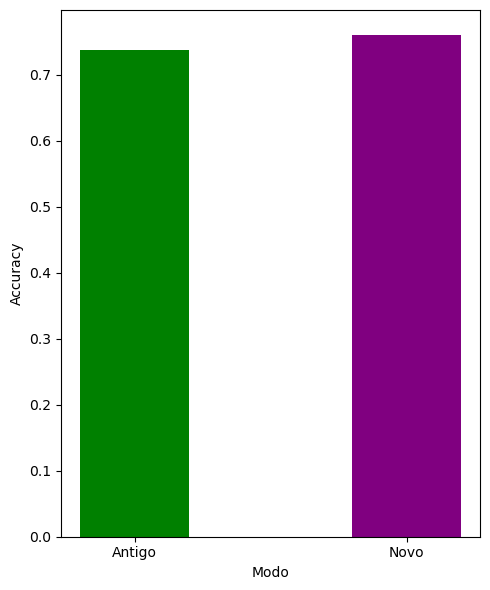

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_bt,y_bt,test_size=0.3,random_state=49)

# inicializar classificador
knn_classifier_antigo = KNNClassifier()
knn_classifier_novo = KNNClassifier_D()

# treinar classificador
knn_classifier_antigo.fit(X_train,y_train)
knn_classifier_novo.fit(X_train,y_train)

# fazer previsão e guardar valores previstos e de teste
pred_antigo = knn_classifier_antigo.predict(X_test)
pred_novo = knn_classifier_novo.predict(X_test)

# accuracy
ac_antigo = ac(pred_antigo,y_test)
print(ac_antigo)
ac_novo = ac(pred_novo,y_test)
print(ac_novo)

plt.figure(figsize=(5, 6))
plt.bar(['Antigo', 'Novo'], [ac_antigo, ac_novo], color=['green', 'purple'], width=0.4)
plt.xlabel('Modo')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

### Avaliação do Algoritmo <a name = "avaliação"></a>
[[voltar ao índice]](#indice)

#### Código dos testes <a name = "ct"></a>
[[voltar a Avaliação do Algoritmo]](#avaliação)

Vamos usar a lista **split_data** anteriormente definida para realizar os testes seguintes em **todos os datasets**:

In [32]:
split_data = [(X_bt,y_bt), (X_breast,y_breast), (X_diabetes,y_diabetes), (X_fertility,y_fertility), 
              (X_haberman,y_haberman), (X_liver,y_liver),(X_lupus,y_lupus), (X_sa,y_sa), (X_weather,y_weather)]

# reúne todos os datasets em causa
ds = {1:'blood_transfusion\n', 
     2:'breast_w\n', 
     3:'diabetes\n', 
     4: 'fertility\n',
     5:'haberman\n',
     6:'liver_disorders\n',
     7:'lupus\n',
     8:'sa_heart\n', 
     9:'weather\n'}

Para analisar graficamente o desempenho de todos os KNN, tanto no original como nos modificados, iremos utilizar dois tipos de gráficos que nos permitem tirar conclusões. Destacamos que para cada teste é criado um split dos dados aleatório, no entanto, dentro de cada teste é utilizado o mesmo 'split' de modo a garantir que os resultados sejam obtidos corretamente, sendo que essa divisão é utilizada nos três algoritmos.

In [33]:
def test(split_data, ds, n_tests = 10):
    for pos, title in ds.items():
        X = split_data[pos-1][0]
        y = split_data[pos-1][1]
        
        accuracy = []
        accuracy_p = []
        accuracy_d = []
        
        for _ in range(n_tests):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
    
            knn = KNNClassifier()
            knn.fit(X_train, y_train)
            knn_pred = knn.predict(X_test)
            accuracy.append(ac(knn_pred,y_test))
            
            knn_p = KNNClassifier_P()
            knn_p.fit(X_train, y_train)
            knn_p_pred = knn_p.predict(X_test)
            accuracy_p.append(ac(knn_p_pred,y_test))
            
            knn_d = KNNClassifier_D()
            knn_d.fit(X_train, y_train)
            knn_d_pred = knn_d.predict(X_test)
            accuracy_d.append(ac(knn_d_pred,y_test))

        # GRÁFICO DE BARRAS
        # Criando a figura e os eixos
        fig, ax = plt.subplots(figsize=(10, 6))

        # Definindo a largura de cada barra
        bar_width = 0.25

        # Definindo a posição das barras no eixo x
        index = np.arange(n_tests)

        # Plotando as barras para cada parâmetro
        ax.bar(index, accuracy, bar_width, label='KNN')
        ax.bar(index + bar_width, accuracy_p, bar_width, label='Pesos')
        ax.bar(index + 2 * bar_width, accuracy_d, bar_width, label='Distância')
        
        # Adicionando os valores dentro das barras na vertical
        for i in range(len(accuracy)):
            ax.text(index[i] - 0.03, accuracy[i] / 2, f'{accuracy[i]:.4f}', rotation=90, fontsize=9)
            ax.text(index[i] + bar_width - 0.03, accuracy_p[i] / 2, f'{accuracy_p[i]:.4f}', rotation=90, fontsize=9)
            ax.text(index[i] + 2 * bar_width - 0.03, accuracy_d[i] / 2, f'{accuracy_d[i]:.4f}', rotation=90, fontsize=9)



        # Configurando os rótulos do eixo x e o título
        ax.set_xlabel('Testes')
        ax.set_ylabel('Accuracy')
        ax.set_title(title)
        ax.set_xticks(index + bar_width)
        ax.set_xticklabels([f'Teste {i+1}' for i in range(n_tests)])

        # Adicionando a legenda
        ax.legend()

        # Exibindo o gráfico
        plt.tight_layout()
        plt.show()
        
        
        # GRÁFICO DE LINHAS
        plt.figure(figsize=(10, 6))
        iterations = range(n_tests)
        plt.plot(iterations, accuracy, label='KNN Normal', marker='o', color='blue')
        plt.plot(iterations, accuracy_p, label='KNN Pesos', marker='o', color='orange')
        plt.plot(iterations, accuracy_d, label='KNN Distâncias', marker='o', color='green')

        plt.title(title)
        plt.xlabel('Testes')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        

#### Testes <a name = "testes"></a>
[[voltar a Avaliação do Algoritmo]](#avaliação)

Durante as fases de teste foram realizadas mais do que 10 iterações, contudo decidimos deixar aquela que consideramos que retrata uma melhor representação dos efeitos dos algoritmos para datasets que podem revelar mais que uma complicação em simultâneo.

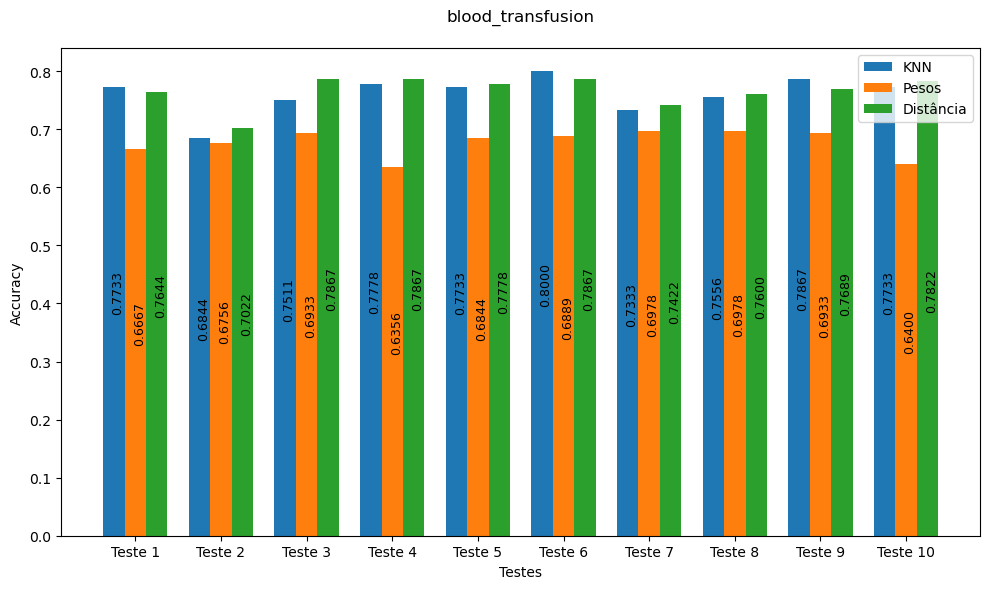

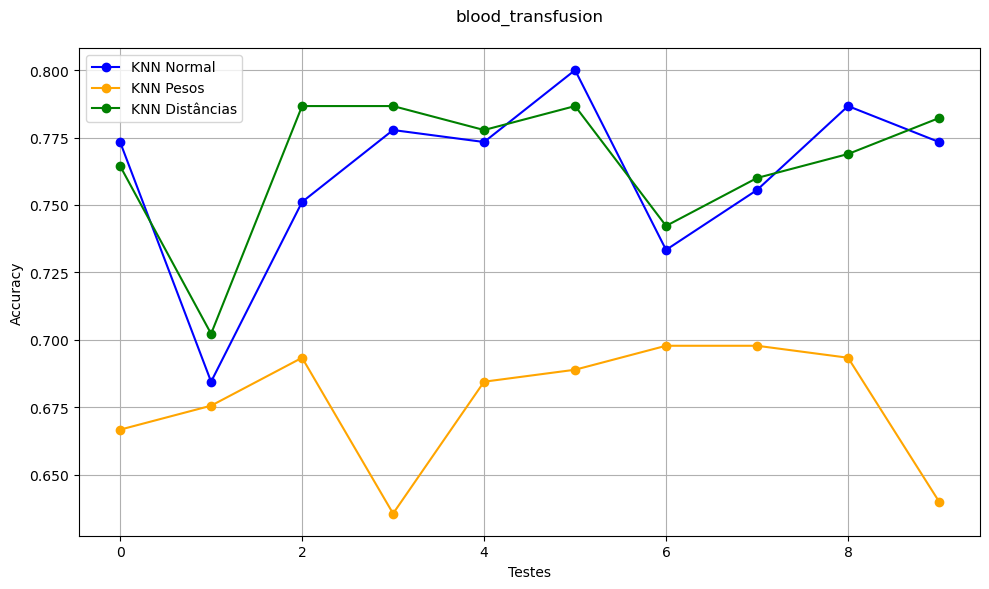

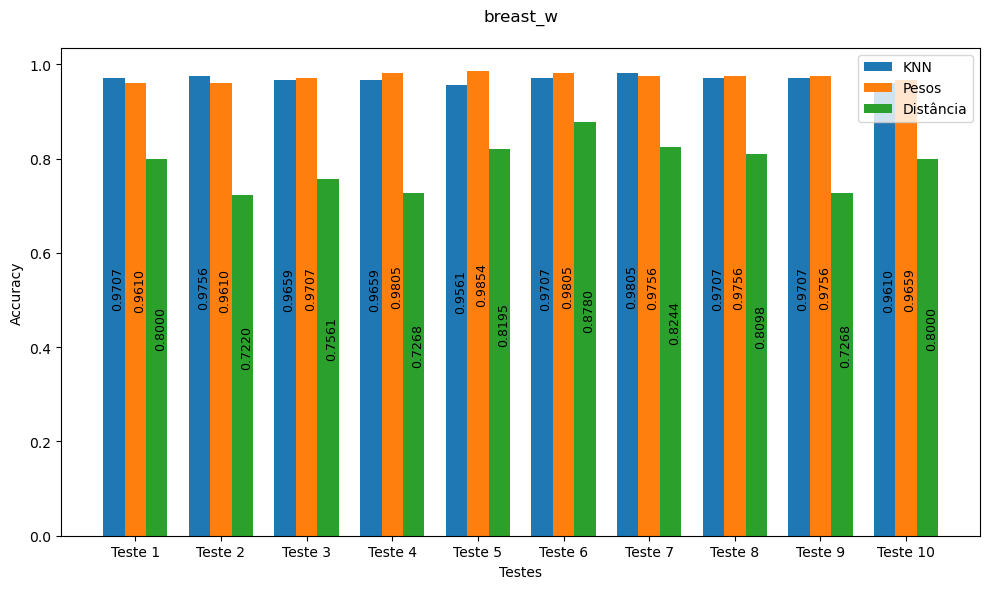

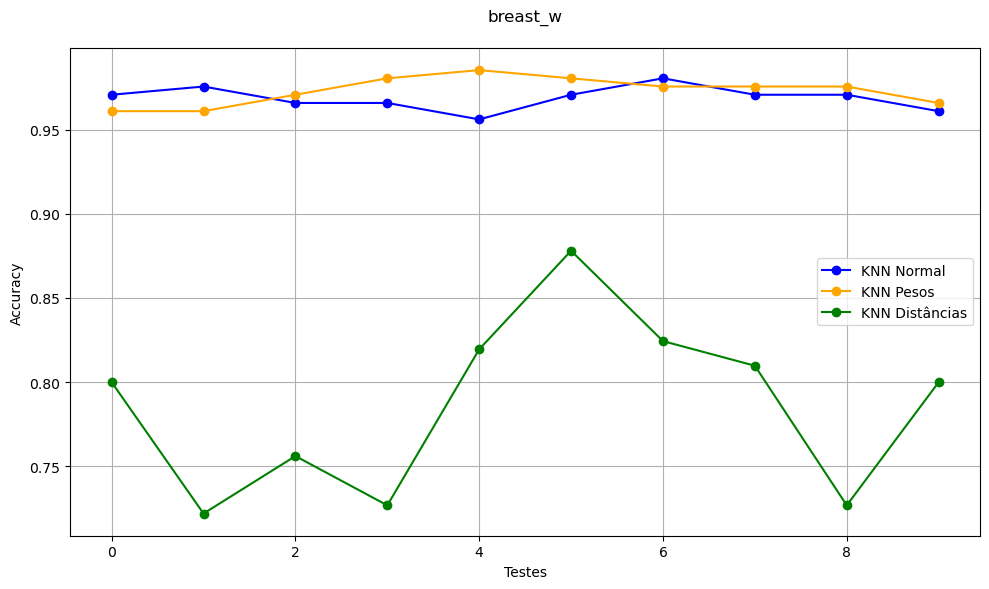

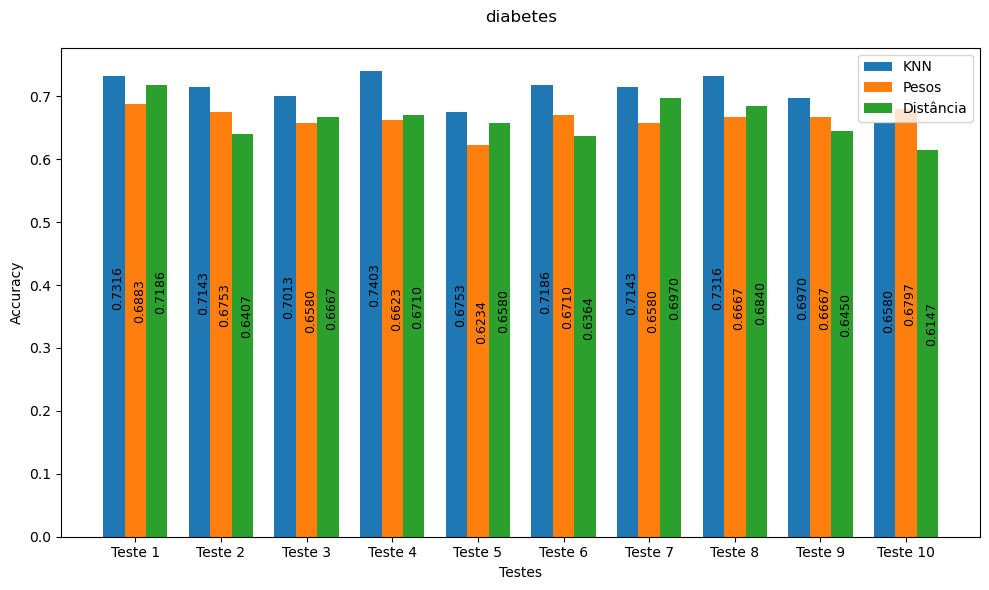

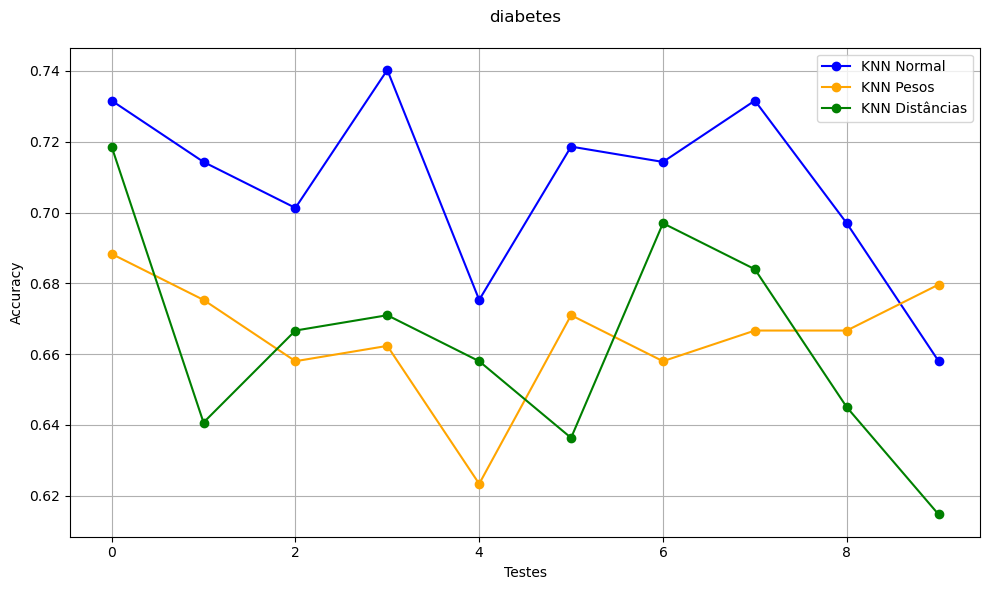

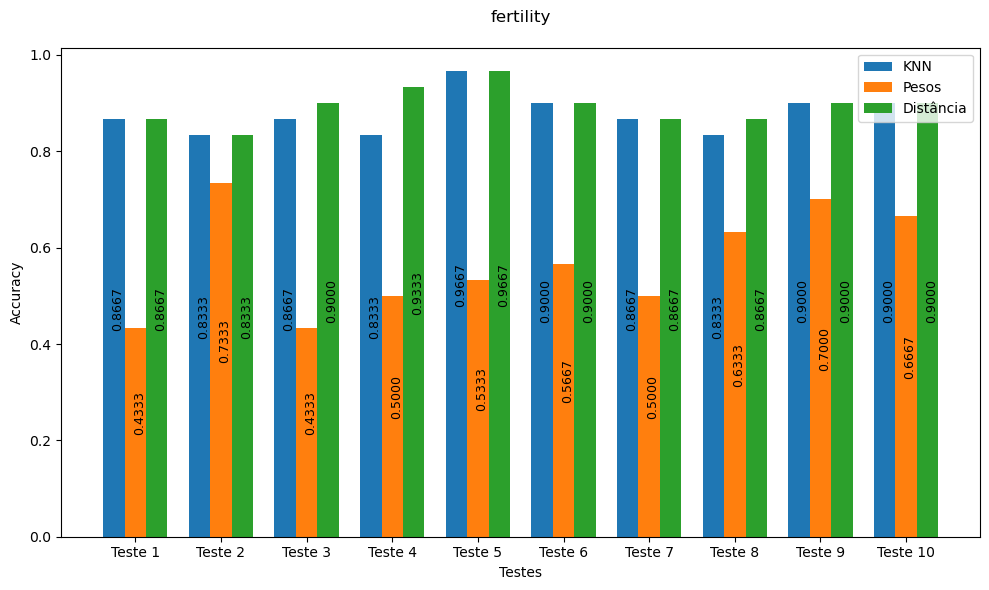

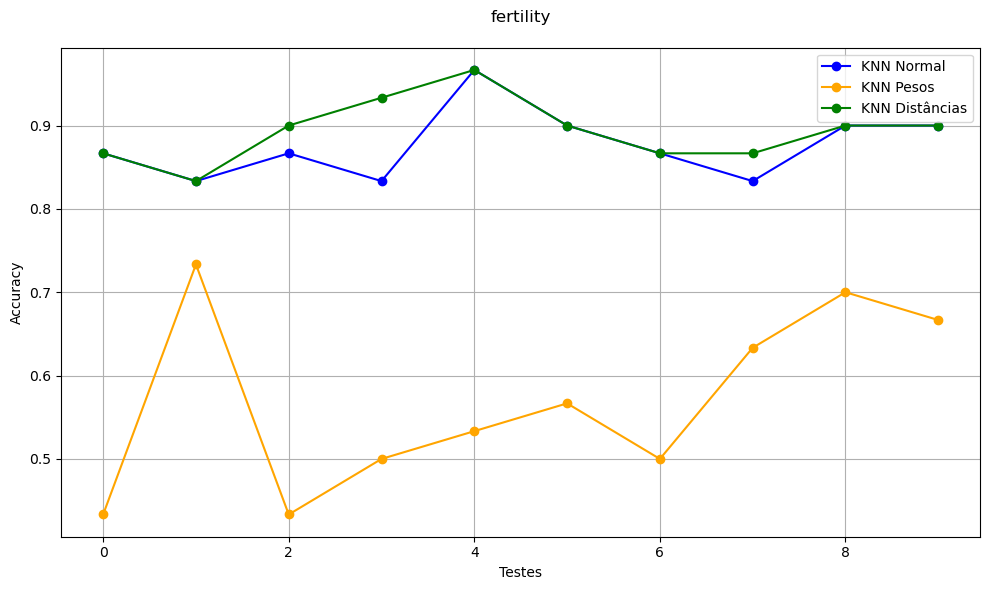

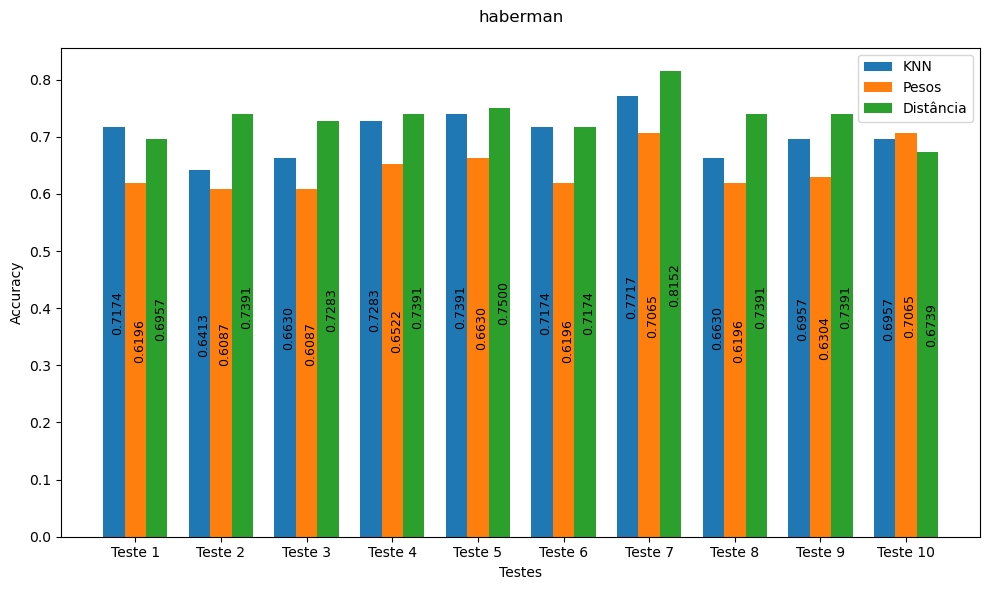

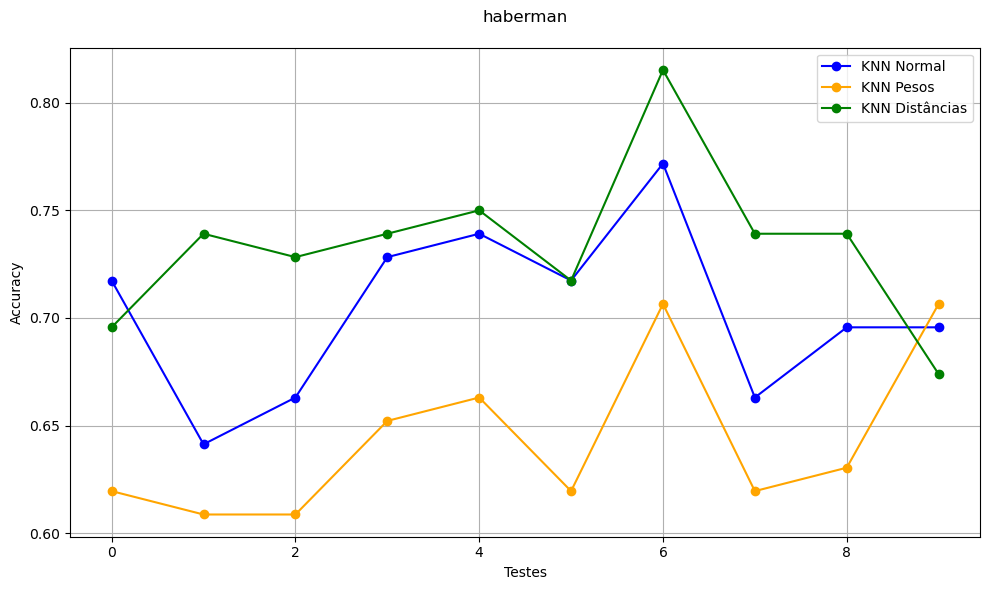

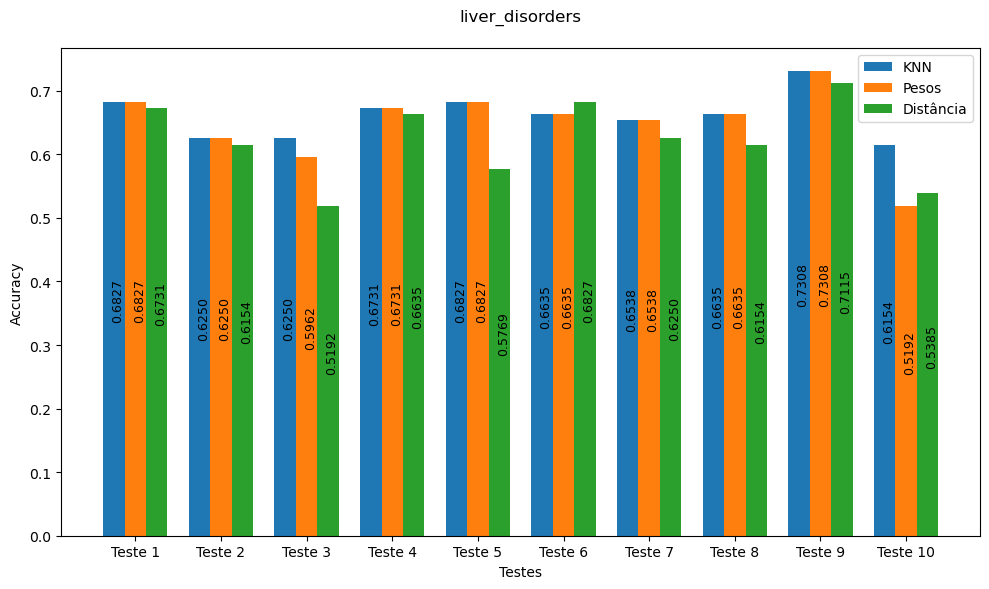

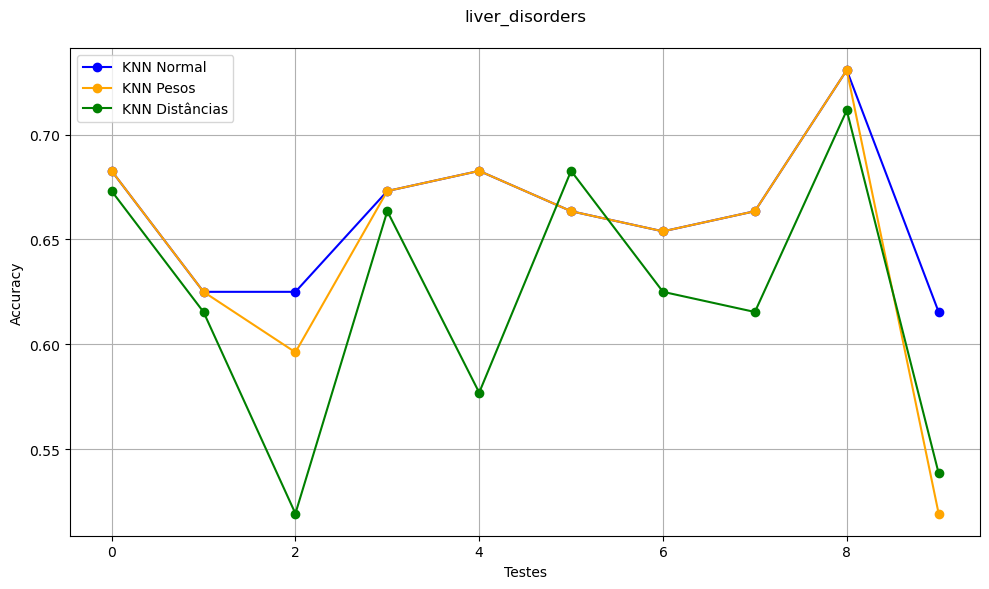

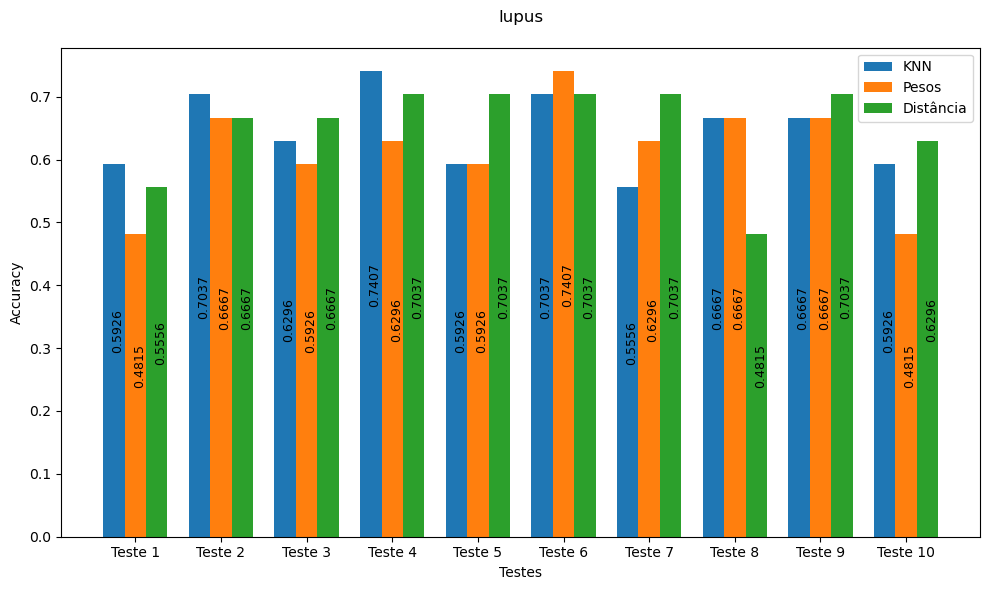

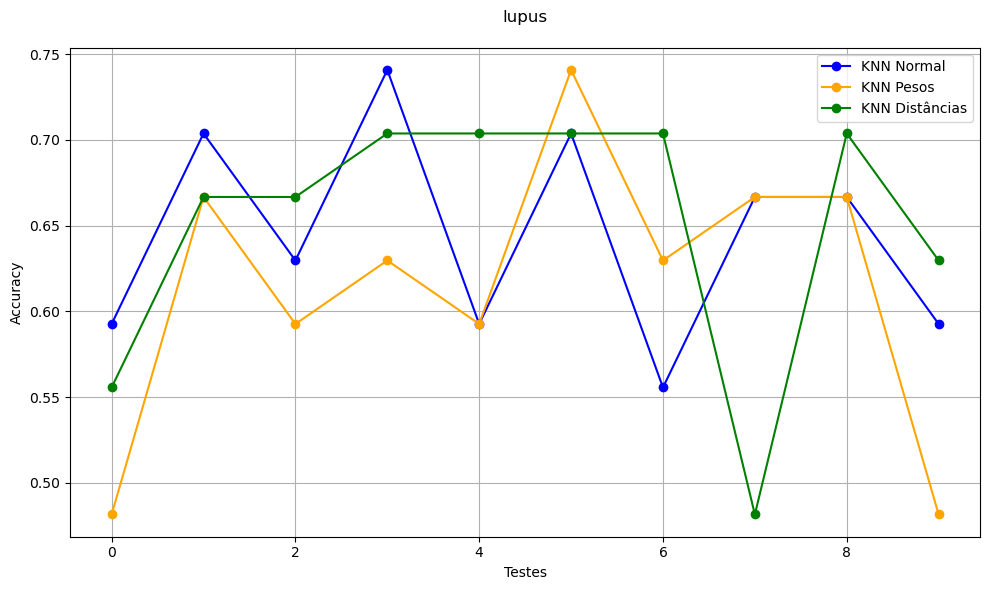

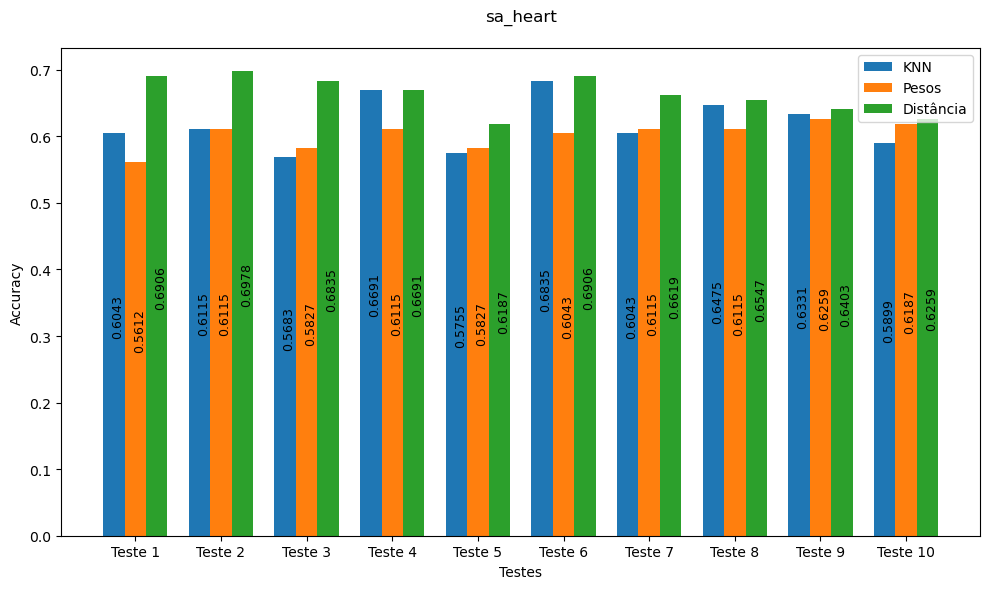

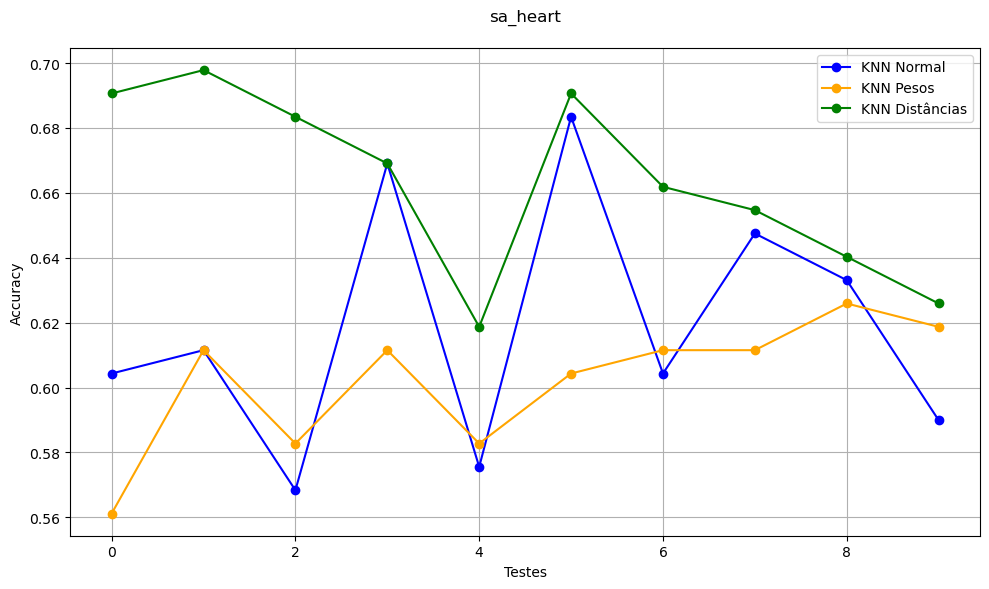

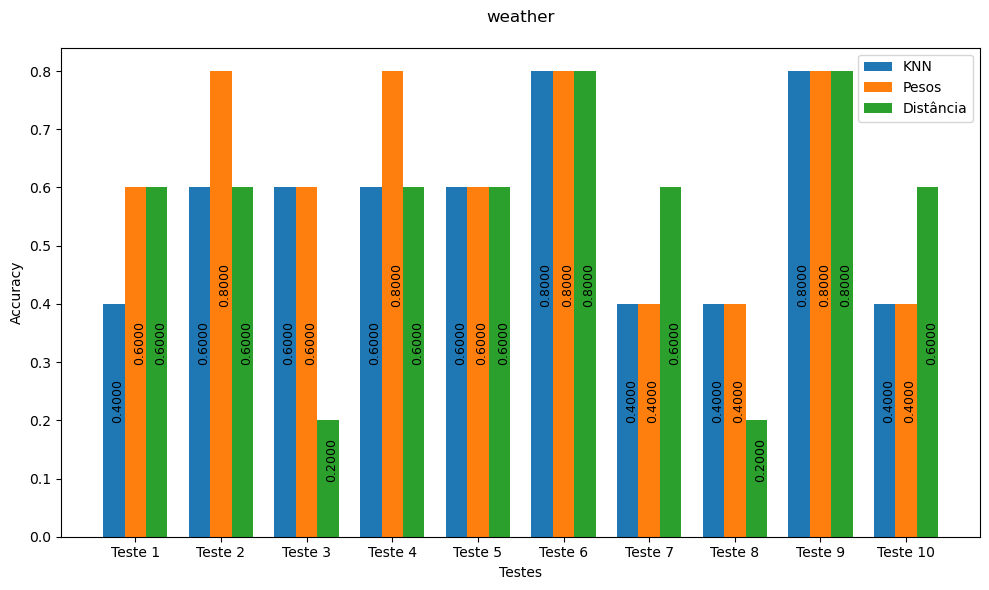

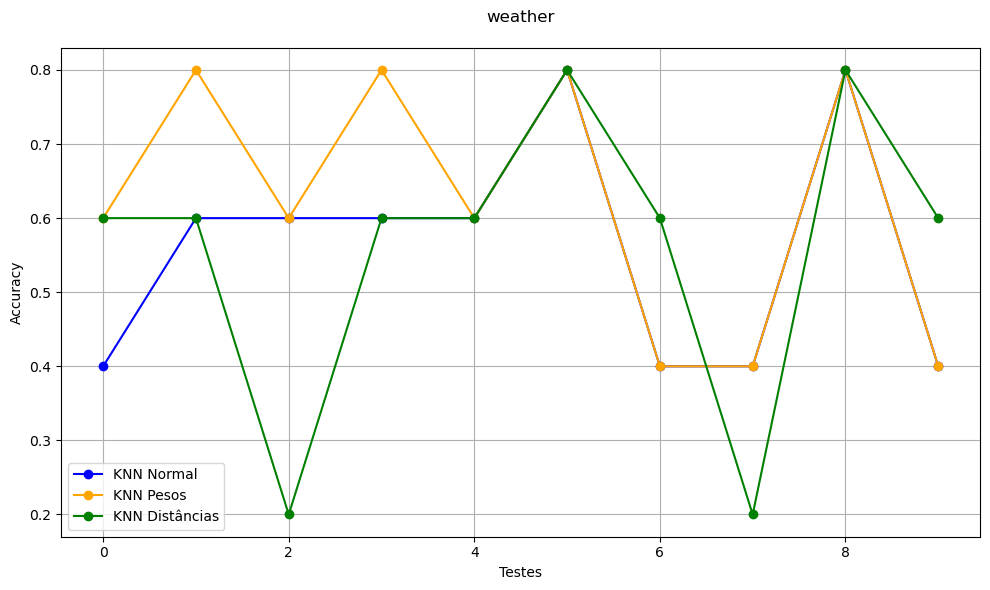

In [34]:
test(split_data, ds, n_tests = 10)

#### Análise dos Resultados <a name = "analise_resultados"></a>
[[voltar a Avaliação do Algoritmo]](#avaliação)

Ao analisarmos os gráficos percebemos que os algoritmos que sofreram melhorias apresentaram resultados mais satisfatórios em comparação ao KNN original, isto é, demonstraram-se melhores.

No entanto, em muitos casos as 'Distâncias Ponderadas' obtiveram melhores resultados que os 'Pesos', o que nos levou a questionar porque é que tal acontecia.  De modo a compreender quais obtiveram melhores resultados observe a seguinte tabela:

                   Distâncias Ponderadas                      Pesos
                --------------------------------------------------------
                     Blood Transfusion                       Breast_w
                     Fertility
                     Haberman
                     Lupus
                     Sa_Heart

A escolha entre distâncias ponderadas e peso de classes depende do contexto específico. Em geral, distâncias ponderadas são melhores quando a distribuição local dos dados é crucial para a classificação, enquanto o peso de classes é mais eficaz para corrigir desequilíbrios globais. Ao observamos graficamente os nossos datasets chegamos à conclusão que em muitos deles havia algum tipo de sobreposição, isto é, as classes encontram-se muito 'misturadas', logo, aplicar medidas que alteram a posição dos dados acaba por amenizar muitas das sobreposições encontradas.

Observamos também que existem alguns casos excecionais, tais como:

- No dataset **'Diabetes'** o knn original demonstrou-se melhor que os restantes algoritmos, sendo que a sua complicação dominante é a de **classes sobrepostas**. Fomos capazes de determinar isto após confirmar que a proporção entre classes não é extremamente desbalanceada contrariamente à forte sobreposição dos dados claramente representada nos scaterplots. Por este motivo, como não existe uma distinção clara entre classes, atribuir pesos aos vizinhos pode na realidade afastá-los em vez de ajudar a detetar qual a resposta correta.

- **'Liver Disorders'** representa um dataset de controlo, ou seja, não é propriamente desbalanceado, tal escolha foi feita com o intuito de mostrar que nem sempre é benéfico usar as otimizações que desenvolvemos. Neste caso, as 'distâncias ponderadas' provaram afetar negativamente o processo de classificação do algoritmo, o que seria de esperar uma vez que este pode afastar ou aproximar valores indevidamente, principalmente se os dados estiverem muito próximos uns dos outros, como vimos nos gráficos. Contudo, a utilização de 'pesos' não demonstrou classificações muito diferentes das do knn original, o que também seria de prever tendo em conta o seu funcionamento. Após escolher os k valores mais próximos, a atribuição de pesos é praticamente insignificante, tal acontece já que os seus valores são proporcionais à frequência dos dados.

- A escassez dos dados, aliada ao seu desbalanceamento, fazem com que o dataset **'Weather'** seja dificil de classificar. A aplicação de medidas de resolução do problema revelou-se, por isso, especialmente eficaz.

Tendo em conta as análises realizadas concluimos que os knn melhorados, seja com pesos ou distâncias ponderadas, apenas obtêm melhores resultados se as classes forem desbalanceadas, dependendo adicionalmente da disposição dos dados.

### Conclusão <a name = "conclusão"></a>
[[voltar ao índice]](#indice)

Através da elaboração deste projeto, fomos capazes de desenvolver competências úteis para futuras análises de dados, otimizações de algoritmos já conhecidos e aprimorar a nossa capacidade de reconhecimento de complicações de datasets e possíveis soluções. Posto isto, conseguimos:

 - Identificar os vários tipos de complicações que podem afetar o algoritmo escolhido, **K-nn**, e sucessivamente decidir atacar o problema das **classes desbalanceadas**;

 - Proceder a um cuidadoso tratamento dos datasets recolhidos da plataforma indicada, OpenML, que se encontra no jupyter 'Tratamento de Dados';

 - Recolher informações sobre o número de exemplos para cada classe em todos os dataset, identificando que se encontram **desbalanceadas**;

 - Realizar uma análise visual de distribuições de classes usando scatterplots para **identificar possíveis complicações não esperadas**;

 - Desenvolver otimizações de K-nn, nomeadamente adição de pesos e de distâncias ponderadas ao algoritmo;

 - Criar uma função de pesos inspirada em BWC (Ponderação Equilibrada de Classes) e implementar no nosso código;

 - Elaborar gráficos de fácil compreensão que mostram as diferenças de performance para os algoritmos implementados.
